<a href="https://colab.research.google.com/github/RuiyunHuang/Chicago_Crime_Analysis/blob/master/Chicago_Crime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Part 0: Environment Setup**

##**0.1 Install package**


In [98]:
!pip install git+https://github.com/python-visualization/folium

  Cloning https://github.com/python-visualization/folium to /tmp/pip-req-build-qxe_2stg
  Running command git clone -q https://github.com/python-visualization/folium /tmp/pip-req-build-qxe_2stg
  Created wheel for folium: filename=folium-0.10.1+6.g4a7532d-py2.py3-none-any.whl size=93921 sha256=41b7bc87eaa8e06ce2ed89520e932065d333c1fe85603f1f28cbf47cbfd54518
  Stored in directory: /tmp/pip-ephem-wheel-cache-8wd0es91/wheels/1e/e1/75/ecbc91fd5dd5d90befb0b533bf7492d38acffa033310731862
Successfully built folium


In [99]:
!pip install tbats

##**0.2 Import packages**

In [0]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 
import folium as fl
from datetime import datetime

sns.set_palette("Blues")
%matplotlib inline

##**0.3 Import data to Colab**

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link = 'https://drive.google.com/open?id=1hkLBV2uhGO6k_BvV6FsQw2nIFZvLfIW2'
fluff, id = link.split('=')
file = drive.CreateFile({'id':id})
file.GetContentFile('crime.csv')

# **Part 1: Data Cleaning**

In [0]:
raw_data=pd.read_csv('crime.csv')

In [103]:
raw_data.head(5)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,10786009,HZ554425,12/16/2016 10:30:00 AM,014XX W 78TH ST,0620,BURGLARY,UNLAWFUL ENTRY,APARTMENT,True,False,612,6.0,17.0,71.0,05,1168161.0,1853026.0,2016,01/07/2020 03:50:13 PM,41.752236,-87.659334,"(41.752235645, -87.659334168)"
1,10734627,HZ494078,10/28/2016 02:00:00 PM,002XX E 92ND ST,0610,BURGLARY,FORCIBLE ENTRY,POOL ROOM,False,False,633,6.0,9.0,49.0,05,1179757.0,1844042.0,2016,01/07/2020 03:50:13 PM,41.727325,-87.617114,"(41.72732535, -87.617114114)"
2,11694006,JC267197,01/01/2016 12:01:00 AM,048XX W WABANSIA AVE,1752,OFFENSE INVOLVING CHILDREN,AGG CRIM SEX ABUSE FAM MEMBER,RESIDENCE,False,True,2533,25.0,37.0,25.0,17,NaN,NaN,2016,01/06/2020 03:49:40 PM,NaN,NaN,NaN
3,10613199,HZ366157,07/27/2016 12:49:00 AM,116XX S AVENUE M,0620,BURGLARY,UNLAWFUL ENTRY,RESIDENCE-GARAGE,True,False,433,4.0,10.0,55.0,05,1201591.0,1828417.0,2016,01/06/2020 03:49:40 PM,41.683923,-87.537663,"(41.683922677, -87.53766346)"
4,11940434,JD102754,09/01/2016 08:00:00 AM,059XX S INDIANA AVE,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,False,False,232,2.0,20.0,40.0,11,NaN,NaN,2016,01/04/2020 03:46:59 PM,NaN,NaN,NaN


In [0]:
raw_data=raw_data.drop(['ID', 'Case Number', 'Location', 'Updated On', 'X Coordinate', 'Y Coordinate'], axis=1);

In [105]:
raw_data.shape

(1063214, 16)

In [106]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1063214 entries, 0 to 1063213
Data columns (total 16 columns):
Date                    1063214 non-null object
Block                   1063214 non-null object
IUCR                    1063214 non-null object
Primary Type            1063214 non-null object
Description             1063214 non-null object
Location Description    1058984 non-null object
Arrest                  1063214 non-null bool
Domestic                1063214 non-null bool
Beat                    1063214 non-null int64
District                1063213 non-null float64
Ward                    1063194 non-null float64
Community Area          1063208 non-null float64
FBI Code                1063214 non-null object
Year                    1063214 non-null int64
Latitude                1051982 non-null float64
Longitude               1051982 non-null float64
dtypes: bool(2), float64(5), int64(2), object(7)
memory usage: 115.6+ MB


In [107]:
raw_data.isnull().sum()

Date                        0
Block                       0
IUCR                        0
Primary Type                0
Description                 0
Location Description     4230
Arrest                      0
Domestic                    0
Beat                        0
District                    1
Ward                       20
Community Area              6
FBI Code                    0
Year                        0
Latitude                11232
Longitude               11232
dtype: int64

#**Part 2: Data Exploration**

###**2.1 Find top 10 crimes**

In [108]:
# take a look at all crime categories
raw_data['Primary Type'].unique()

array(['BURGLARY', 'OFFENSE INVOLVING CHILDREN', 'DECEPTIVE PRACTICE',
       'SEX OFFENSE', 'CRIM SEXUAL ASSAULT', 'BATTERY', 'CRIMINAL DAMAGE',
       'THEFT', 'NARCOTICS', 'HOMICIDE', 'ROBBERY', 'OTHER OFFENSE',
       'WEAPONS VIOLATION', 'MOTOR VEHICLE THEFT', 'ASSAULT',
       'PUBLIC PEACE VIOLATION', 'CRIMINAL TRESPASS', 'NON-CRIMINAL',
       'INTERFERENCE WITH PUBLIC OFFICER', 'ARSON',
       'CONCEALED CARRY LICENSE VIOLATION', 'STALKING', 'KIDNAPPING',
       'LIQUOR LAW VIOLATION', 'PROSTITUTION', 'INTIMIDATION',
       'NON-CRIMINAL (SUBJECT SPECIFIED)', 'OBSCENITY', 'GAMBLING',
       'NON - CRIMINAL', 'OTHER NARCOTIC VIOLATION', 'PUBLIC INDECENCY',
       'HUMAN TRAFFICKING'], dtype=object)

In [0]:
#remove those non-crimes
non_crime=set(['NON - CRIMINAL', 'NON-CRIMINAL', 'NON-CRIMINAL (SUBJECT SPECIFIED)'])

raw_data=raw_data[~raw_data['Primary Type'].isin(non_crime)]

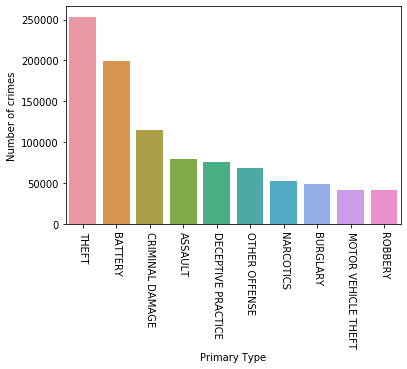

In [110]:
#list top 10 crimes
crime_by_type=raw_data.groupby('Primary Type').size().sort_values(ascending=False)\
                      .rename('Number of crimes').reset_index().head(10)

plt.figure()
plt.xticks(rotation=-90)
sns.barplot(x='Primary Type', y='Number of crimes', data=crime_by_type)

###**2.2 List top 10 dangerous districts**

In [111]:
raw_data['District'].unique()

array([ 6., 25.,  4.,  2., 16., 15.,  5.,  7., 20., 14., 19.,  8., 12.,
       22., 10., 17.,  3., 11.,  9., 18., 24.,  1., 31., nan])

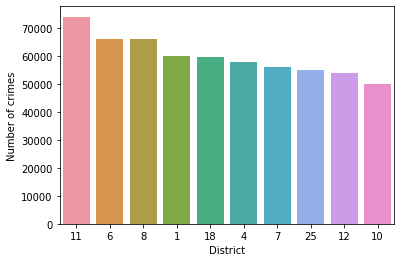

In [112]:
# list top district
crime_by_district=raw_data.groupby('District').size().sort_values(ascending=False)\
                          .rename('Number of crimes').reset_index().head(10)
crime_by_district['District']=crime_by_district['District'].astype(int).astype(str)

plt.figure()
sns.barplot(x='District', y='Number of crimes', data=crime_by_district, order=crime_by_district['District'])

###**2.3 Time dependence of crimes**

In [0]:
# parse date 
raw_data['Date']=pd.to_datetime(raw_data['Date'], format='%m/%d/%Y %I:%M:%S %p')
raw_data['Day']=raw_data['Date'].dt.day
raw_data['Month']=raw_data['Date'].dt.month
raw_data['DayofWeek']=raw_data['Date'].dt.dayofweek
raw_data['Hour']=raw_data['Date'].dt.hour

In [0]:
months_temp=['January', 'February', 'March', 'April', 'May', 'June', 'July',
          'August', 'September', 'October', 'November', 'December']

**By month**

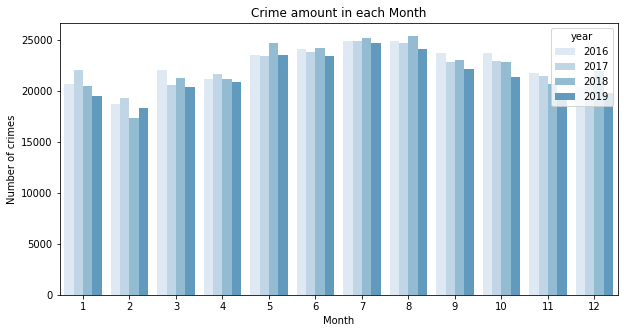

In [115]:
years=[2016, 2017, 2018, 2019]
crime_by_Month=pd.DataFrame()

for _ in years:
  tmp=raw_data[raw_data.Year == _].groupby('Month')\
  .size().rename('Number of crimes').reset_index()
  tmp['year']=_
  crime_by_Month=pd.concat([crime_by_Month, tmp])

plt.figure(figsize=[10, 5])
plt.title('Crime amount in each Month')
sns.barplot(x=crime_by_Month.Month, y=crime_by_Month['Number of crimes'], hue=crime_by_Month.year, data=crime_by_Month)

**By day of week**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


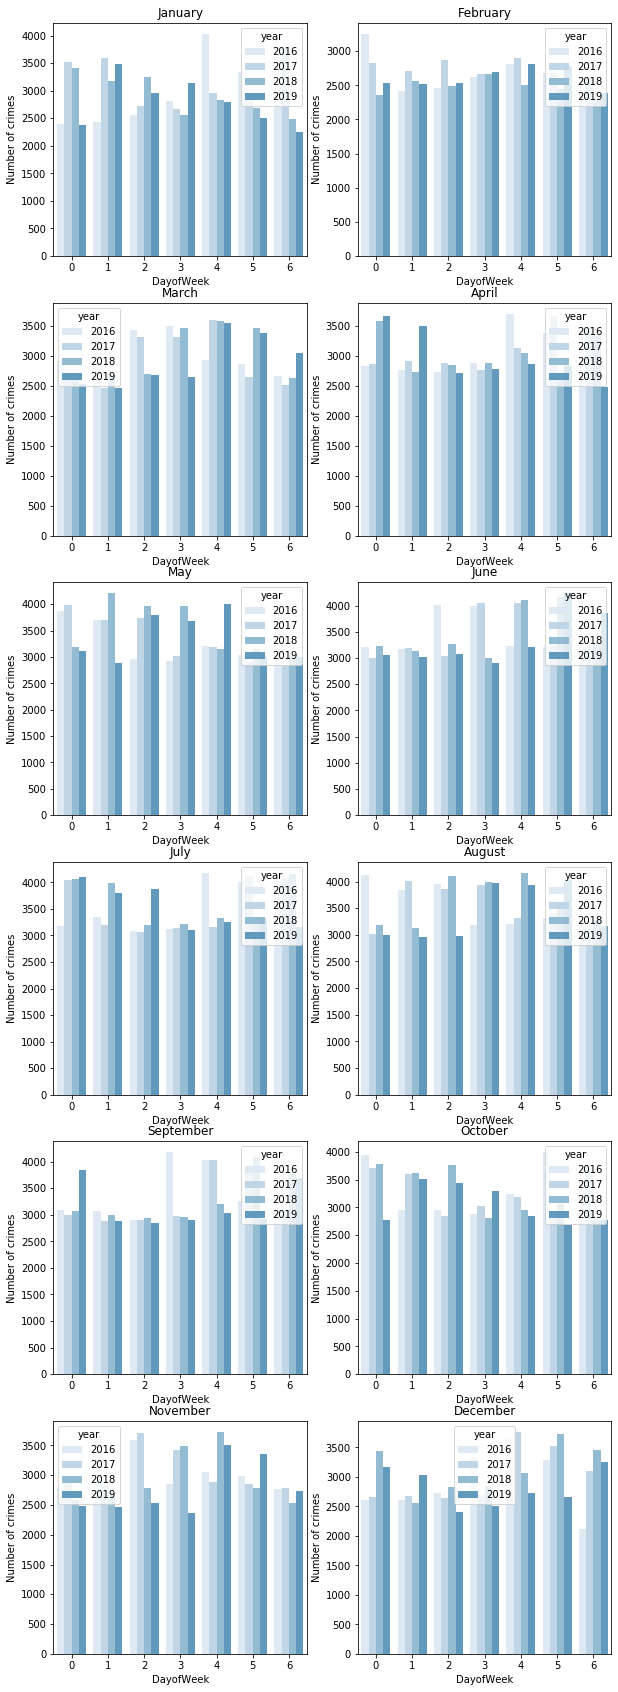

In [116]:
months=np.arange(1, 13, 1)
plt.figure(figsize=[10, 30])

for i in months:
  crime_by_dayofweek=pd.DataFrame()
  tmp=raw_data[(raw_data.Month == i)]
  for j in years:
    tmp_j=tmp[raw_data.Year == j].groupby('DayofWeek')\
    .size().rename('Number of crimes').reset_index()
    tmp_j['year']=j
    crime_by_dayofweek=pd.concat([crime_by_dayofweek, tmp_j])
  plt.subplot(6, 2, i)
  plt.title(months_temp[i-1])
  sns.barplot(x=crime_by_dayofweek.DayofWeek, y=crime_by_dayofweek['Number of crimes'], hue=crime_by_dayofweek.year, data=crime_by_dayofweek)

**By hour**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


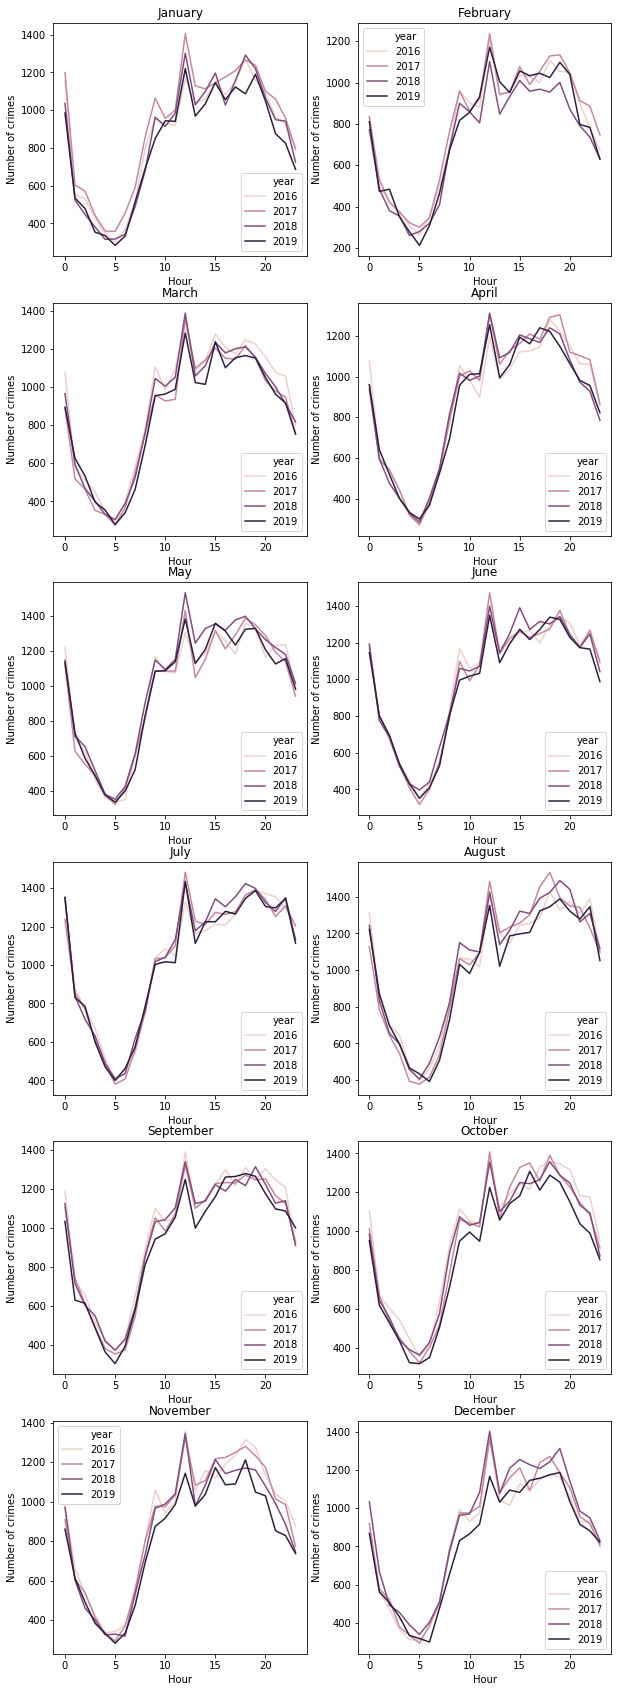

In [117]:
plt.figure(figsize=[10, 30])

for i in months:
  crime_by_hour=pd.DataFrame()
  tmp=raw_data[(raw_data.Month == i)]
  for j in years:
    tmp_j=tmp[raw_data.Year == j].groupby('Hour')\
    .size().rename('Number of crimes').reset_index()
    tmp_j['year']=j
    crime_by_hour=pd.concat([crime_by_hour, tmp_j])
  plt.subplot(6, 2, i)
  plt.title(months_temp[i-1])
  sns.lineplot(x=crime_by_hour.Hour, y=crime_by_hour['Number of crimes'], hue=crime_by_hour.year, data=crime_by_hour)

#**Part 3: Visualization**

In [0]:
chicago_cor=[41.8781, -87.6298]
Time_type='Hour'
Crime_type='ROBBERY'

In [0]:
location_list=raw_data[(~raw_data.Latitude.isnull()) & (raw_data.Year == 2019) & (raw_data['Primary Type'] == Crime_type)]\
                      [['Latitude', 'Longitude', Time_type]]
location_list['xy']=location_list[['Latitude', 'Longitude']].values.tolist()
location_list=location_list[['xy', Time_type]].groupby(Time_type).agg(list)
lc=location_list['xy'].values.tolist()

In [120]:
from folium.plugins import HeatMapWithTime

m = fl.Map(location=chicago_cor, zoom_start=11)
HeatMapWithTime(lc, index=location_list.index.tolist(), radius=10).add_to(m)
m

#**Part 4: Modeling**

##**4.1: K-means clustering on locations**

In [0]:
from sklearn.cluster import KMeans
mpl.style.use('default')

In [0]:
# set summer as tour months
tour_months=set([6, 7, 8])

# select training data
train_kmeans = raw_data[(raw_data.Year==2019) & (raw_data.Month.isin(tour_months)) & (raw_data['Primary Type'] == Crime_type)]\
                       [['Latitude', 'Longitude']].dropna()

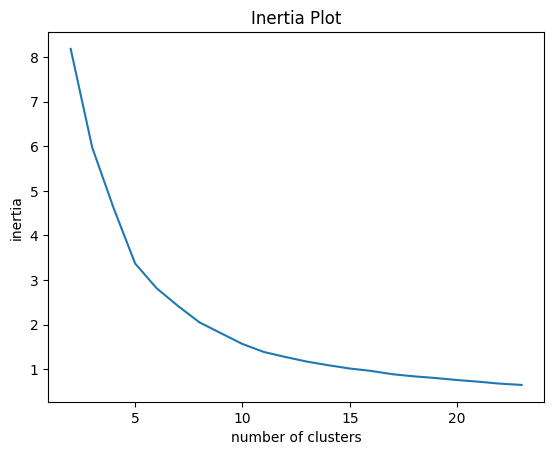

In [123]:
# draw inertia curve to decide number of clusters
inertia=[]
min_n=2
max_n=24
steps=1
for n in range(min_n, max_n, steps):
  result=KMeans(n)
  result.fit(train_kmeans)
  inertia.append(result.inertia_)

plt.figure()
plt.plot(np.arange(min_n, max_n, steps), np.array(inertia))
plt.title('Inertia Plot')
plt.xlabel('number of clusters')
plt.ylabel('inertia')
plt.show()

In [0]:
# fit best model
bestmodel_kmeans=KMeans(10)
bestmodel_kmeans.fit(train_kmeans)
prediction_kmeans=bestmodel_kmeans.predict(train_kmeans)

In [0]:
# count number of crime for each clusters
prediction_kmeans=pd.concat([train_kmeans.reset_index(drop=True),
                             pd.DataFrame(prediction_kmeans, columns=['label'])], axis=1)
regions_sum=prediction_kmeans.groupby('label').count().reset_index()
prediction_kmeans=prediction_kmeans.join(regions_sum, on='label', rsuffix='_0')
prediction_kmeans.rename(columns = {'Latitude_0':'number of crimes'}, inplace = True)

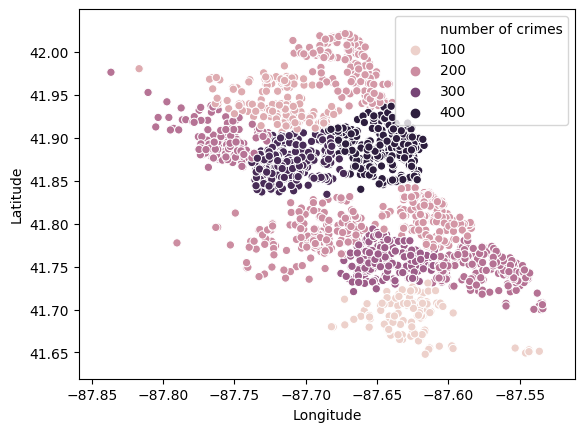

In [126]:
tmp=sns.scatterplot(x=prediction_kmeans.Longitude, y=prediction_kmeans.Latitude, hue=prediction_kmeans['number of crimes'])

###**4.2.1: Data processing**

In [0]:
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [0]:
years=[2016, 2017, 2018, 2019]

In [0]:
# get the crime number for each day from 2016 to 2019
raw_data['Day'] = raw_data['Date'].values.astype('datetime64[D]')
number_by_month = raw_data[raw_data['Year'].isin(years)].groupby('Day').size().rename('Number of crimes').reset_index()
number_by_month = number_by_month.set_index('Day', drop=True)

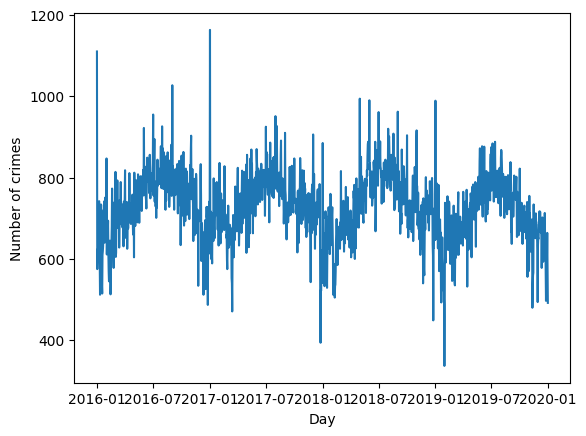

In [130]:
plt.figure()
sns.lineplot(x=number_by_month.index, y=number_by_month['Number of crimes'], data=number_by_month)

###**4.2.2: Seasonal decomposition**

Text(0.5, 0.98, 'Additive Decompose')

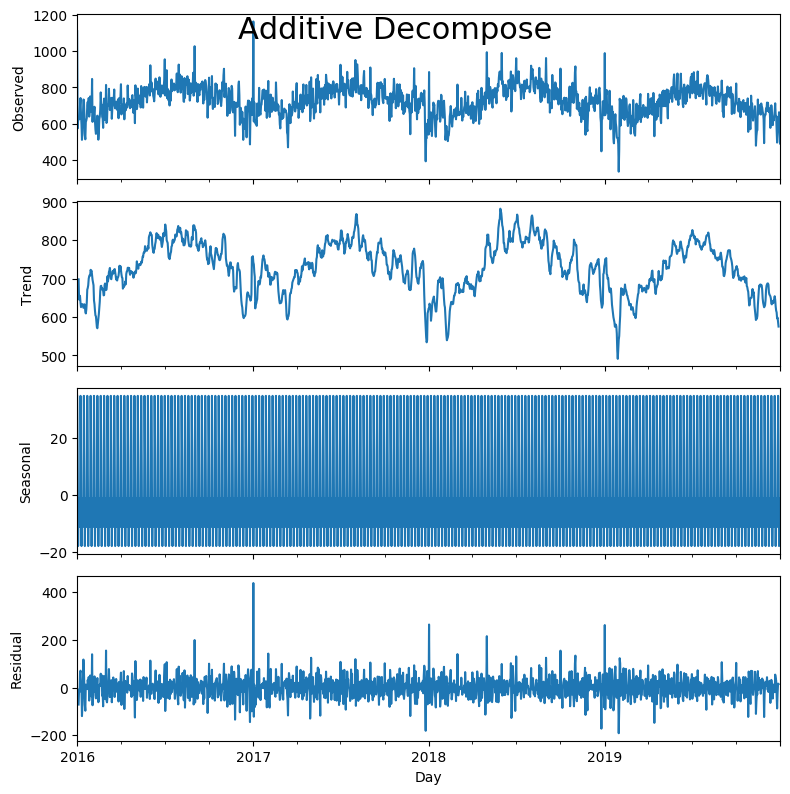

In [131]:
# seasonal decomposition
additive=sm.tsa.seasonal_decompose(number_by_month)

plt.rcParams.update({'figure.figsize': (8,8)})
additive.plot().suptitle('Additive Decompose', fontsize=22)

###**4.2.3: Stationary check**

In [0]:
# split data into train and test
train_data=number_by_month.loc['2016-01-01':'2018-12-31']
test_data=number_by_month.loc['2019-01-01':]

In [133]:
# stationary check
def ADF_check(data):
  result = sm.tsa.stattools.adfuller(data['Number of crimes'])
  print(f'ADF Statistic: {result[0]}')
  print(f'p-value: {result[1]}')
  for key, value in result[4].items():
      print('Critial Values:')
      print(f'{key}, {value}')

print('**Train_data**')
ADF_check(train_data)

print('\n')

print('**Test_data**')
ADF_check(test_data)

**Train_data**
ADF Statistic: -3.3319278566505637
p-value: 0.013510240223847796
Critial Values:
1%, -3.4364081161854747
Critial Values:
5%, -2.8642149051061954
Critial Values:
10%, -2.5681942108302214


**Test_data**
ADF Statistic: -1.2140913902313424
p-value: 0.6675047673378167
Critial Values:
1%, -3.4491725955218655
Critial Values:
5%, -2.8698334971428574
Critial Values:
10%, -2.5711883591836733


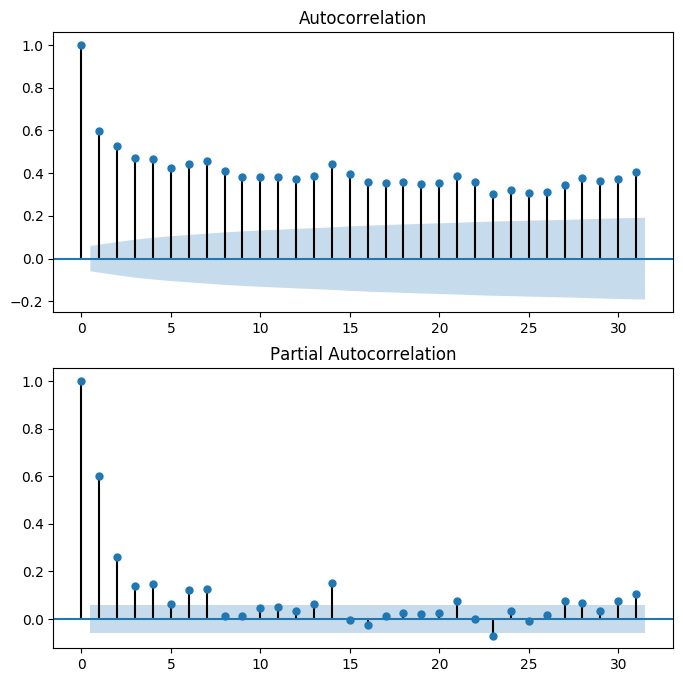

In [134]:
from statsmodels.graphics.tsaplots import plot_acf 
from statsmodels.graphics.tsaplots import plot_pacf 

fig, ax = plt.subplots(nrows=2,ncols=1)
plot_acf(train_data.values, ax = ax[0])
plot_pacf(train_data.values, ax = ax[1])
display()

###**4.2.4 Parameter selection and model testing**

In [0]:
# add frequency to datetime
train_data=train_data.asfreq('D')
test_data=test_data.asfreq('D')

In [136]:
# cross validation to find best parameters for SARIMAX
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

tmp_min=float('inf')
cross_val=[]

start = datetime. now()

for _order in pdq:
  for _param in seasonal_pdq:
    try:
      model=SARIMAX(train_data, order=_order, 
                seasonal_order=_param)
      result=model.fit()
      if not cross_val or result.aic < tmp_min:
        cross_val=[result, _order, _param]
        tmp_min=result.aic
    except:
      continue

end = datetime. now()

print("Total time =", (end-start))

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Total time = 0:01:00.121081


In [137]:
SARIMAX_best_result=cross_val[0]
SARIMAX_best_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                  Number of crimes   No. Observations:                 1096
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -6007.905
Date:                           Wed, 22 Jan 2020   AIC                          12023.810
Time:                                   16:49:42   BIC                          12043.778
Sample:                               01-01-2016   HQIC                         12031.368
                                    - 12-31-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2602      0.026     10.028      0.000       0.209       0.311
ma.L1         -0.8898      0.017    -53.766      0.000      -0.922      -0.857
ma.S.L7       -0.9976      0.053    -18.681      0.000      -1.102      -0.893
sigma2      3549.6372    200.416     17.711      0.000    3156.829    3942.446
===================================================================================
Ljung-Box (Q):                       69.03   Jarque-Bera (JB):              2123.19
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                             0.78
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

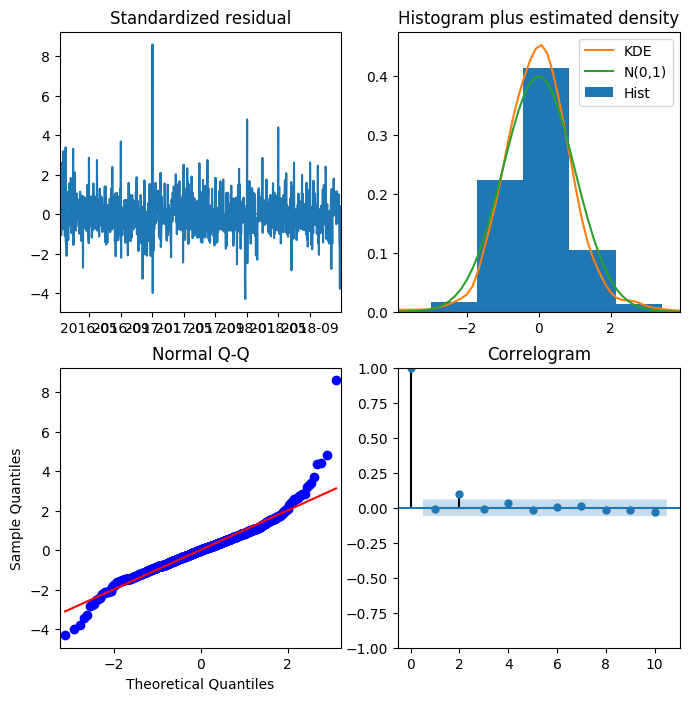

In [138]:
SARIMAX_best_result.plot_diagnostics()
plt.show()

In [0]:
# function to plot result
def plot_result(train_data, fit, pred):
    mpl.style.use('seaborn')
    fig, ax = plt.subplots()
    ax.set_title('Number of Crimes vs. Time')
    ax.plot(train_data.index, train_data.values, 'C0', label='raw data')
    ax.plot(fit.index, fit.values, 'C1', label='fitted')
    ax.plot(pred.index, pred.values, 'C2', label='prediction')
    plt.legend()
    plt.show()

def abs_error(fit, pred):
    print('The mean absolute error for prediction is', np.mean(np.abs(np.add(fit.values, -1*pred.values))))

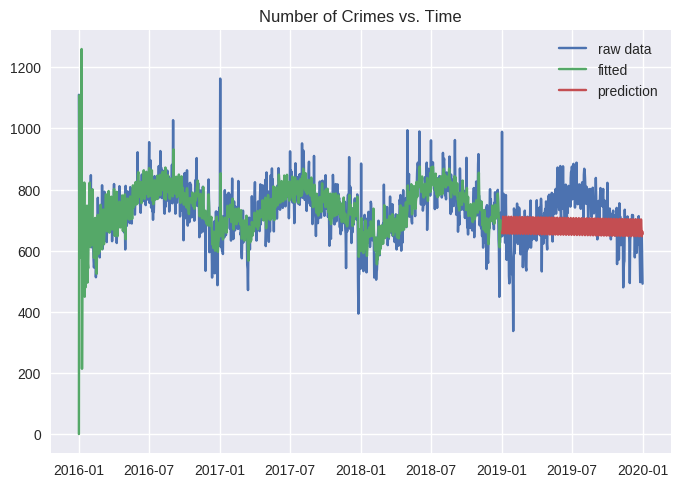

In [140]:
# ploting result 
SARIMAX_fit = SARIMAX_best_result.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False)
SARIMAX_fit_mean=SARIMAX_fit.predicted_mean

SARIMAX_pred = SARIMAX_best_result.get_forecast(steps=365)
SARIMAX_pred_mean=SARIMAX_pred.predicted_mean

plot_result(number_by_month, SARIMAX_fit_mean, SARIMAX_pred_mean)

In [141]:
# calculate absolute error for prediction
abs_error(test_data['Number of crimes'], SARIMAX_pred_mean)

The mean absolute error for prediction is 71.25338779834094


###**4.2.5 Try TBATS model**

In [142]:
from tbats import TBATS

start = datetime. now()

estimator = TBATS(seasonal_periods=(7, 365.25))
model_tbats = estimator.fit(train_data)

end = datetime. now()

print("Total time =", (end-start))

Total time = 0:06:05.025937


In [0]:
tbats_fit=pd.Series(model_tbats.y_hat, index=train_data.index)

tbats_pred = model_tbats.forecast(steps=365)
tbats_pred=pd.Series(tbats_pred, index=test_data.index)

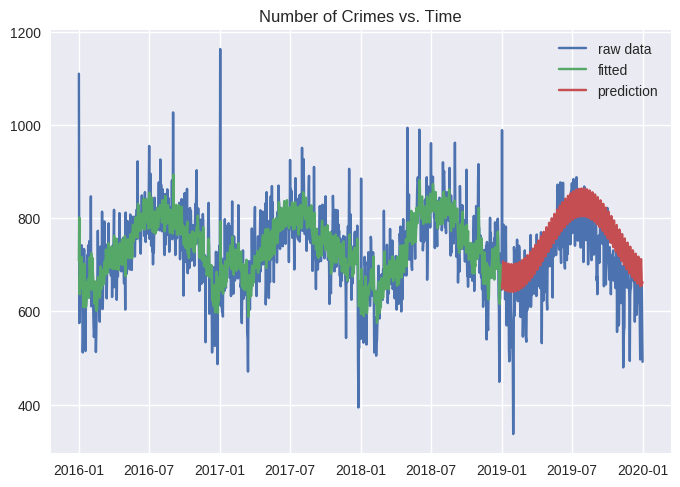

In [144]:
plot_result(number_by_month, tbats_fit, tbats_pred)

In [145]:
abs_error(test_data['Number of crimes'], tbats_pred)

The mean absolute error for prediction is 54.44435314941803
